In [50]:
from __future__ import print_function, division
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io, transform
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from torch.optim import Adam

# use gpu or not
if torch.cuda.is_available():
    device = 'cuda'
    print('using gpu')
else:
    device = 'cpu'
    
device = torch.device(device)

using gpu


In [15]:
path = "./imm_face_db/"
IMG_SHAPE = (80, 60)
# IMG_SHAPE = (640, 480)

class FaceDataset(Dataset):

    def __init__(self, transform=None, flag = "train"):
        # read all data and split them 
#         self.train_x = []
#         self.train_y = []
#         self.val_x = []
#         self.val_y = []
        self.all_x = []
        self.all_y = []
        self.transform = transform
        allfiles = []
        for root, dirs, files in os.walk(path):
            allfiles = allfiles + files
        allfiles = list(filter(lambda x: 'jpg' in x, allfiles))
        for file in allfiles:
            image = Image.open(path + file) 
            self.all_x.append(image.resize(IMG_SHAPE))
            f = open(path + file.replace("jpg","asf"))
            marks = f.readlines() 
            f.close() 
            marks = marks[16: 74]
            marks = list(map(lambda x: [IMG_SHAPE[0] * float(x.split('\t')[2].replace(' ','')), IMG_SHAPE[1] * float(x.split('\t')[3].replace(' ',''))], marks))
            # marks = np.array(marks)[-5]
            marks = np.array(marks).astype('float32').reshape(58,2)
            self.all_y.append(marks)
            # nose_keypoint = 
            # self.all_y.append(marks)
        if flag=="train":
        # all 6 images of the first 32 persons (index 1-32) as the training set (total 32 x 6 = 192 images)
            self.all_x = self.all_x[0:32]
            self.all_y = self.all_y[0:32]
        elif flag=="val":
        # the images of the remaining 8 persons (index 33-40) (8 * 6 = 48 images) as the validation set.
            self.all_x = self.all_x[32:40]
            self.all_y = self.all_y[32:40]
    
    def __len__(self):
        return len(self.all_x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
#         print(idx)
#         print(self.all_x[idx], self.all_y[idx])
#         print(self.all_x[idx].shape, self.all_y[idx].shape)
        sample = {'image': self.all_x[idx], 'marks': self.all_y[idx]}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

class Rescale(object):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        w, h = image.shape[:2]
        new_w, new_h = int(w*self.scale), int(h*self.scale)
        image = image.reshape(IMG_SHAPE[0], IMG_SHAPE[1])
        img = Image.fromarray(np.uint8((image + 0.5)*255))
        img = img.resize((new_w, new_h))
        image = np.array(img)
        image = image.astype(np.float32)/255-0.5
        image = image.reshape(new_w, new_h, 1)
        marks = marks * self.scale
        return {'image': image, 'marks': marks}
    
class RandomCrop(object):
    def __init__(self, output_x, output_y):
            self.output_size = (output_x, output_y)

    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        w, h = image.shape[:2]
        new_w, new_h = self.output_size
        left = np.random.randint(0, w - new_w)
        top = np.random.randint(0, h - new_h)
        image = image[left: left + new_w, top: top + new_h]
        marks = marks - [left, top]
        return {'image': image, 'marks': marks}

# wait for update
class ToTensor(object):
    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'marks': torch.from_numpy(marks)}
    
class myColorJitter(object):
    def __init__(self, brightness=0):
        self.brightness = [1-brightness, 1+brightness]
        
    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        bf = torch.tensor(1.0).uniform_(self.brightness[0], self.brightness[1]).item()
        image = transforms.functional.adjust_brightness(image, bf)
        image = transforms.functional.adjust_saturation(image, 2)
        return {'image': image, 'marks': marks}
    
class myFlip(object):
    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        w, h = image.size
        image = transforms.functional.hflip(image)
        marks = marks * [-1, 1] + [w, 0]# [w - marks[0], h]
        return {'image': image, 'marks': marks}
    
class PIL2Array(object):
    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        image = np.array(image.convert('L'))
        image = image.astype(np.float32)/255-0.5
        image = image.reshape(IMG_SHAPE[0], IMG_SHAPE[1], 1)
        return {'image': image, 'marks': marks}

class myRotation(object):
    def __init__(self, degree=0):
        self.degree = degree
        
    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        w, h = image.size
        r_image = image.copy()
        r_image = r_image.rotate(self.degree, expand= False)
#         image = image.resize(IMG_SHAPE)
        angle = np.radians(self.degree)
        cos_ = np.cos(angle)
        sin_ = np.sin(angle)
        w = w/2
        h = h/2
        rotation = np.array([[cos_, -sin_], [sin_, cos_]])
        marks = marks - [w, h]
        marks = marks.dot(rotation)
        marks = marks + [w, h]
        return {'image': r_image, 'marks': marks}


0 torch.Size([1, 80, 60]) torch.Size([58, 2])


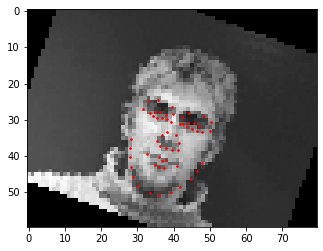

1 torch.Size([1, 80, 60]) torch.Size([58, 2])


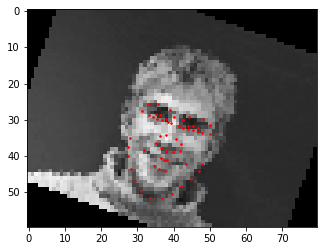

2 torch.Size([1, 80, 60]) torch.Size([58, 2])


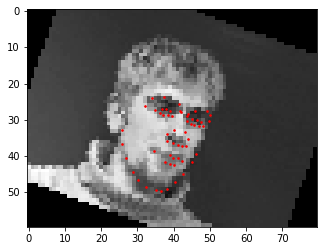

3 torch.Size([1, 80, 60]) torch.Size([58, 2])


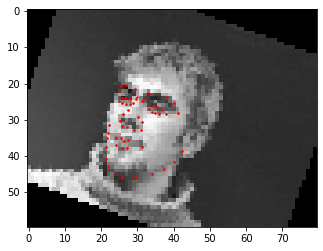

4 torch.Size([1, 80, 60]) torch.Size([58, 2])


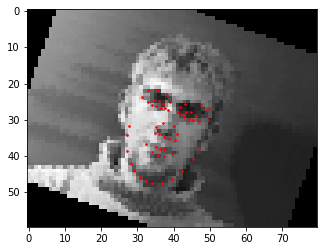

0 torch.Size([8, 1, 80, 60]) torch.Size([8, 58, 2])
1 torch.Size([8, 1, 80, 60]) torch.Size([8, 58, 2])
2 torch.Size([8, 1, 80, 60]) torch.Size([8, 58, 2])
3 torch.Size([8, 1, 80, 60]) torch.Size([8, 58, 2])
0 torch.Size([8, 1, 80, 60]) torch.Size([8, 58, 2])


In [21]:


transforms_ = transforms.Compose([
    myColorJitter(0.5),
    myRotation(20),
    myFlip(),
    PIL2Array(),
    ToTensor()])

face_dataset_train = FaceDataset(transform=transforms_, flag = "train")
face_dataset_val = FaceDataset(transform=None, flag = "val")

# task 1.1 Sampled image from your dataloader visualized with ground-truth keypoints.
for i in range(len(face_dataset_train)):
    sample = face_dataset_train[i]
    image = sample['image']
    marks = sample['marks']
    print(i, image.shape, marks.shape)
    plt.figure()
    plt.imshow(image.reshape(IMG_SHAPE[1],IMG_SHAPE[0]), cmap='gray')
    plt.scatter(marks[:, 0], marks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  
    plt.show()
    if i == 4:
        plt.show()
        break

face_dataset_train = FaceDataset(transform=transforms_, flag = "train")
face_dataset_val = FaceDataset(transform=transforms_, flag = "val")
batch_size = 8
dataloader_train = DataLoader(face_dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_val = DataLoader(face_dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader_train):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['marks'].size())
    
for i_batch, sample_batched in enumerate(dataloader_val):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['marks'].size())



Computing the "Mid-way Face"

myNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv6): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=

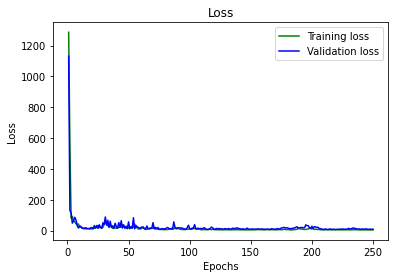

In [23]:


class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        # conv 1
        self.conv1 = nn.Sequential(nn.Conv2d(1, 64, 7, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), )
        # conv 2
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2))
        # conv 3
        self.conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True))
        # conv 4
        self.conv4 = nn.Sequential(nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True))
        # conv 5
        self.conv5 = nn.Sequential(nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True))
        # conv 6
        self.conv6 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Sequential(nn.Linear(128, 512),  # 6*6 from image dimension 
            nn.ReLU(inplace=True))
        self.fc2 = nn.Linear(512, 116)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, self.num_flat_features(x))
#         print(x.shape)
        x = self.fc1(x) #
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
#         print(num_features)
        return num_features

cnn = myNet()
cnn.to(device)
print(cnn)
# print(cnn)

loss_fn = nn.MSELoss()
optimizer = Adam(cnn.parameters(), lr=0.001)

def getAccuracy(y1, y2):
    acc = 0.0
    y1 = y1.cpu().detach().numpy()
    y2 = y2.cpu().detach().numpy()
    for i in range(len(y1)):
        area1 = min(y1[i][0], y2[i][0])*min(y1[i][1], y2[i][1])
        area2 = max(y1[i][0], y2[i][0])*max(y1[i][1], y2[i][1])
#         area1 = area1.cpu().detach().numpy()[0]
#         area2 = area2.cpu().detach().numpy()[0]
#         print(area1)
#         print(area2)
#         exit()
        acc = acc + area1/area2
    return acc/(len(y1))
        
train_loss = []
train_acc = []
val_loss = []
val_acc= []

epochs = range(1, 251)

for i in epochs:
    print("enter the "+str(i)+" epoch")
    epoch_loss = []
    epoch_acc = []
    for i_batch, sample_batched in enumerate(dataloader_train):
#         image = sample_batched['image'][0]
#         marks = sample_batched['marks'][0]
#         print(i, image.shape, marks.shape)
#         plt.figure()
#         plt.imshow(image.reshape(IMG_SHAPE[1],IMG_SHAPE[0]), cmap='gray')
#         marks = marks.reshape(58, 2)
#         plt.scatter(marks[:, 0], marks[:, 1], s=10, marker='.', c='r')
#         plt.pause(0.001)  
#         plt.show()
#         exit()
        cnn.train()
        x_train = sample_batched['image'].float().to(device)
        y_train = sample_batched['marks'].float().to(device)
        outputs = cnn(x_train)
        y_train = y_train.reshape(8, 116)
        optimizer.zero_grad()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        epoch_acc.append(getAccuracy(outputs, y_train))
    train_loss.append(sum(epoch_loss)/len(epoch_loss))
    train_acc.append(sum(epoch_acc)/len(epoch_acc))
    
    
    epoch_loss = []
    epoch_acc = []
    for i_batch, sample_batched in enumerate(dataloader_val):
        cnn.eval()
        x_val = sample_batched['image'].float().to(device)
        y_val = sample_batched['marks'].float().to(device)
        outputs = cnn(x_val)
        y_val = y_val.reshape(8, 116)
        loss = loss_fn(outputs, y_val)
        prediction = outputs.cpu().data.numpy()
        epoch_loss.append(loss.item())
        epoch_acc.append(getAccuracy(outputs, y_train))
    val_loss.append(sum(epoch_loss)/len(epoch_loss))
    val_acc.append(sum(epoch_acc)/len(epoch_acc))
    
print(train_acc)
print(val_acc)

# task 1.2: Plot the train and validation accuracy during the training process.
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


The Morph Sequence

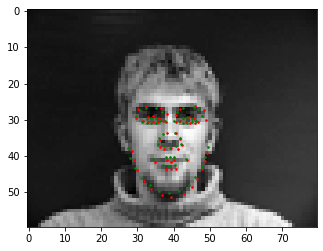

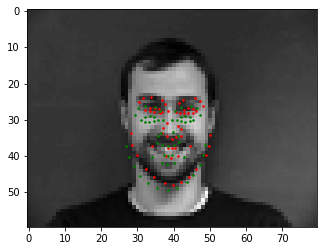

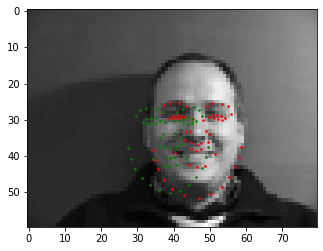

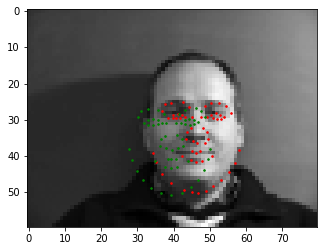

In [22]:
# task 1.3: 2 facial images which the network detects the nose correctly, 
# and 2 more images where it detects incorrectly
face_dataset_train = FaceDataset(transform=None, flag = "train")
best_two = []
worst_two = []
best_two_samples = []
worst_two_samples = []

cnn.eval()

for i in range(len(face_dataset_train)):
    sample = face_dataset_train[i]
    image = sample['image']
    image = np.array(image.convert('L'))
    image = image.astype(np.float32)/255-0.5
    image = image.reshape(IMG_SHAPE[0], IMG_SHAPE[1], 1)
    marks = sample['marks']
    x_val = torch.from_numpy(np.array([image.transpose((2, 0, 1))])).float().to(device)
    y_val = torch.from_numpy(np.array([marks])).float().to(device)
    outputs = cnn(x_val)
    prediction = outputs.cpu().data.numpy()
    acc = getAccuracy(outputs, y_val.reshape(1, 116))
    if len(best_two_samples) < 2:
        best_two_samples.append({'image': image, 'marks': marks, 'pre': prediction.reshape(58, 2)})
        worst_two_samples.append({'image': image, 'marks': marks, 'pre': prediction.reshape(58, 2)})
        best_two.append(acc)
        worst_two.append(acc)
    else:
        if(acc<max(best_two)):
            index_ = best_two.index(min(best_two))
            best_two[index_] = acc
            best_two_samples[index_] = {'image': image, 'marks': marks, 'pre': prediction.reshape(58, 2)}
        if(acc>min(worst_two)):
            index_ = worst_two.index(min(worst_two))
            worst_two[index_] = acc
            worst_two_samples[index_] = {'image': image, 'marks': marks, 'pre': prediction.reshape(58, 2)}

# print(best_two_samples)
# print(worst_two_samples)
    
for sample in best_two_samples:
    plt.figure()
    image = sample['image']
    marks = sample['marks']
    prediction = sample['pre']
    plt.imshow(image.reshape(IMG_SHAPE[1],IMG_SHAPE[0]), cmap='gray')
    plt.scatter(marks[:, 0], marks[:, 1], s=10, marker='.', c='r')
    plt.scatter(prediction[:, 0], prediction[:, 1], s=10, marker='.', c='green')
    plt.pause(0.001)  
    plt.show()

for sample in worst_two_samples:
    plt.figure()
    image = sample['image']
    marks = sample['marks']
    prediction = sample['pre']
    plt.imshow(image.reshape(IMG_SHAPE[1],IMG_SHAPE[0]), cmap='gray')
    plt.scatter(marks[:, 0], marks[:, 1], s=10, marker='.', c='r')
    plt.scatter(prediction[:, 0], prediction[:, 1], s=10, marker='.', c='green')
    plt.pause(0.001)  
    plt.show()

The "Mean face" of a population

[Conv2d(1, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2)), Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


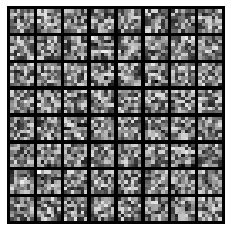

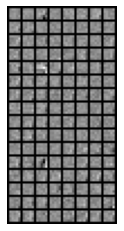

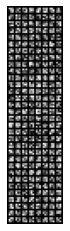

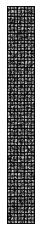

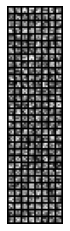

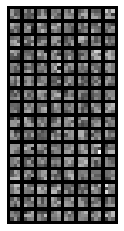

In [52]:
layers = cnn._modules.items()
# print(cnn_layers)
cnn_layers = []
for i in layers:
    for j in i:
        if isinstance(j, torch.nn.modules.Linear):
            continue
        if isinstance(j[0], torch.nn.modules.conv.Conv2d):
            cnn_layers.append(j[0])

print(cnn_layers)

nshow = 8
    
filters = list(map(lambda x: x.weight.data.cpu(), cnn_layers))
# print(filters)
for fi in filters:
    plt.axis('off')
    plt.ioff()
    n, c, w, h = fi.shape
    fi = fi[:,0,:,:].unsqueeze(dim=1)
    rows = np.min((fi.shape[0] // nshow + 1, 64))    
    grid = torchvision.utils.make_grid(fi, nrow=nshow, normalize=True, padding=1).numpy()
    plt.imshow(grid.transpose((1, 2, 0)))
    
    
    plt.show()

# weight = cnn.conv1.weight.data.numpy()
# plt.imshow(weight[0, ...])